# Подключаем необходимые библиотеки

In [1]:
import os

import torchvision.datasets
import torchvision.transforms

import torch.nn

import matplotlib.pyplot as plt

import time

# Загружаем данные

In [2]:
dir_name = os.getcwd()
train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = torchvision.transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/jupyter/work/resources
    Split: Train
    StandardTransform
Transform: ToTensor()

Покажем что классы сбаллансированы

In [4]:
counts = [0] * 10
for i in range(len(train_dataset)):
  counts[train_dataset[i][1]] += 1
print(counts)

[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


Покажем примеры изображений

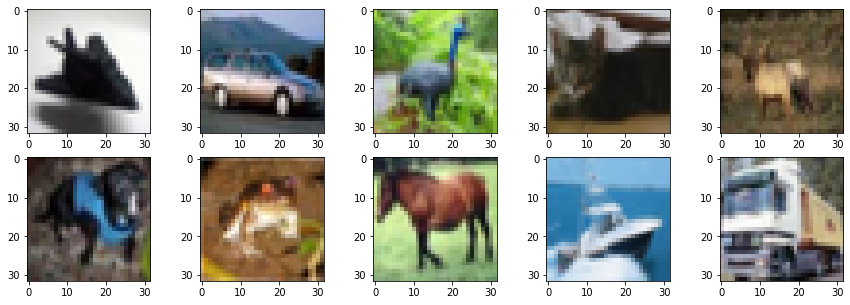

In [5]:
fig, axes = plt.subplots(2, 5, figsize = (15, 5))
for label in range(10):
  for i in range(len(train_dataset)):
    if label == train_dataset[i][1]:
      axes[label // 5, label % 5].imshow(train_dataset[i][0].permute(1, 2, 0))
      break
plt.show()

# Создадим модель нейронной сети

In [6]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.model = torch.nn.Sequential(
                # 100 x ((32-3+2*1)/1+1) x ((32-3+2*1)/1+1) = 100 x 32 x 32
                torch.nn.Conv2d(3, 100, kernel_size=3, padding=1),
                torch.nn.ReLU(),
                # 300 x ((32-3+2*1)/1+1) x ((32-3+2*1)/1+1) = 300 x 32 x 32
                torch.nn.Conv2d(100, 300, kernel_size=3, padding=1),
                torch.nn.ReLU(),
                # 300 x ((32-3)/2+1) x ((32-3)/2+1) = 300 x 15 x 15
                torch.nn.MaxPool2d(kernel_size = 3, stride = 2),
                torch.nn.ReLU(),
                torch.nn.Flatten(),
                torch.nn.Linear(300*15*15, 10))

    # Переопределение метода, вызываемого в процессе прямого прохода
    def forward(self, x):
        return self.model(x)

model = Model()
model

Model(
  (model): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 300, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=67500, out_features=10, bias=True)
  )
)

In [7]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = 50, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = 50, shuffle = False
)

# Обучим модель

In [8]:
model = Model()

learning_rate = 0.1
num_epochs = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

total_time = 0

for epoch in range(num_epochs):
    start = time.time()
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_time = time.time() - start
    total_time += epoch_time

    print(f'Epoch {epoch}')
    print(f'    accuracy on train data : {get_accuracy(train_data_loader, model)}')
    print(f'    epoch_time = {int(epoch_time // 60)} min, {int(epoch_time % 60)} sec')

Epoch 0
    accuracy on train data : 0.6182199716567993
    epoch_time = 2 min, 10 sec
Epoch 1
    accuracy on train data : 0.6996600031852722
    epoch_time = 2 min, 13 sec
Epoch 2
    accuracy on train data : 0.7549200057983398
    epoch_time = 2 min, 13 sec
Epoch 3
    accuracy on train data : 0.7725800275802612
    epoch_time = 2 min, 13 sec
Epoch 4
    accuracy on train data : 0.796500027179718
    epoch_time = 2 min, 12 sec
Epoch 5
    accuracy on train data : 0.8568599820137024
    epoch_time = 2 min, 13 sec
Epoch 6
    accuracy on train data : 0.8810200095176697
    epoch_time = 2 min, 11 sec
Epoch 7
    accuracy on train data : 0.9013400077819824
    epoch_time = 2 min, 9 sec
Epoch 8
    accuracy on train data : 0.909600019454956
    epoch_time = 2 min, 9 sec
Epoch 9
    accuracy on train data : 0.9442399740219116
    epoch_time = 2 min, 9 sec
Epoch 10
    accuracy on train data : 0.9357799887657166
    epoch_time = 2 min, 9 sec
Epoch 11
    accuracy on train data : 0.90798002

Покажем результирующую точность на тестовой выборке и общее время обучения модели

In [9]:
print(f'accuracy on test data  : {get_accuracy(test_data_loader, model)}\n')
print(f'total time = {total_time}')

accuracy on test data  : 0.7042999863624573

total time = 2592.5540659427643
